In [1]:
# Initial imports
from pathlib import Path
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# # Keras modules
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense



In [2]:
df = pd.read_csv(Path('runner_result_runner_result.csv'))
df = df.drop(columns="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13188 entries, 0 to 13187
Data columns (total 89 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   meetingName                      13188 non-null  object 
 1   meetingDate                      13188 non-null  object 
 2   raceNumber                       13188 non-null  int64  
 3   runnerNumber                     13188 non-null  int64  
 4   location                         0 non-null      float64
 5   weatherCondition                 13022 non-null  object 
 6   trackCondition                   13022 non-null  object 
 7   raceName                         13188 non-null  object 
 8   raceStartTime                    13188 non-null  object 
 9   raceDistance                     13188 non-null  int64  
 10  trackDirection                   0 non-null      float64
 11  raceClassConditions              13188 non-null  object 
 12  runnerName        

In [3]:
# df['horse_id'] = df['runnerName'].apply( lambda x: hash(x))
# df.info()
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
df['runnerName'] = LabelEncoder().fit_transform(df['runnerName'])
df['runnerName']



0        2876
1        7051
2        1198
3        5173
4        4381
         ... 
13183    2555
13184    6203
13185    6035
13186    2886
13187    5528
Name: runnerName, Length: 13188, dtype: int32

In [4]:
# df['finishingPosition'] = df['finishingPosition'].apply( lambda x: 1/x if x>=1 and x<=3 else 0.1 )

# df = df.sort_values(by=['finishingPosition'], ascending=False)





In [5]:
# df

In [6]:
runner_starts_df = df.iloc[:, 17:31]
runner_wins_df = df.iloc[:,31:45]
runner_placings_df = df.iloc[:,45:59]
trainer_starts_df = df.iloc[:,59:64]
trainer_wins_df = df.iloc[:,64:69]
trainer_placings_df = df.iloc[:,69:74]
rider_starts_df = df.iloc[:,74:79]
rider_wins_df = df.iloc[:,79:84]
# rider_placings_df = df.iloc[:,84:]
rider_placings_df = df.iloc[:,84:89]
fixed_wins_df = df.iloc[:,15:17] 

# horse_df = df.iloc[:,89:] 
horse_df = df.iloc[:,12:13] 

runners_df = pd.concat([runner_starts_df,runner_wins_df,runner_placings_df],axis=1,join='inner')
trainer_df = pd.concat([trainer_starts_df,trainer_wins_df,trainer_placings_df],axis=1,join='inner')
rider_df = pd.concat([rider_starts_df,rider_wins_df,rider_placings_df],axis=1,join='inner') 

df = df.iloc[:,0:15]


In [7]:
horse_df

,runnerName
0,2876
1,7051
2,1198
3,5173
4,4381
...,...
13183,2555
13184,6203
13185,6035
13186,2886


In [8]:
df['finishingPosition'] = df['finishingPosition'].apply( lambda x: x if x>=1 and x<=3 else 0 )



# df['finishingPosition'] = df['finishingPosition'].apply( lambda x: 1/x if x>=1 and x<=3 else 0 )

# df.finishingPosition.value_counts()


In [9]:
# Convert categorical features to numerical
weatherCondition_df = pd.get_dummies(df.weatherCondition)
trackCondition_df = pd.get_dummies(df.trackCondition)
raceClassConditions_df = pd.get_dummies(df.raceClassConditions)
# raceName = pd.get_dummies(df.raceName)
# meetingName = pd.get_dummies(df.meetingName)

In [10]:
# df = pd.concat([weatherCondition,trackCondition,raceClassConditions,raceName,meetingName,df],axis=1)
# df = pd.concat([df,weatherCondition,trackCondition,raceClassConditions],axis=1)
# df

In [11]:
y = df.finishingPosition
raceDistance_df = df['raceDistance']
y


0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
13183    2.0
13184    0.0
13185    0.0
13186    1.0
13187    0.0
Name: finishingPosition, Length: 13188, dtype: float64

In [12]:
df = df.drop(columns=['weatherCondition','trackCondition','location','trackDirection','runnerName','riderName'])
df = df.drop(columns=['meetingDate','raceStartTime','raceClassConditions','raceName','meetingName'])
X = df.drop(columns='finishingPosition')
X = X.drop(columns=['raceNumber','runnerNumber'])
X = X.drop(columns='raceDistance')

X

""
0
1
2
3
4
...
13183
13184
13185
13186


In [13]:
def deep_net(X,y,include_dfs,epochs,no_hidden_nodes,no_layers,verbose=2):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    import matplotlib.pyplot as plt

    if len(include_dfs) > 0:
        for data_frame in include_dfs:
            X = pd.concat([X, data_frame],axis=1,join='inner')

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
  
    neuron = Sequential()
    
    number_inputs = len(X_test_scaled[0])
    number_hidden_nodes = no_hidden_nodes
    neuron.add(Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))
    
    count = 0
    while count < no_layers:
        neuron.add(Dense(units=number_hidden_nodes, activation="relu"))
        count += 1

    neuron.add(Dense(units=1, activation="linear"))

    neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

    model = neuron.fit(X_train_scaled, y_train, validation_split=0.3, epochs=epochs, verbose=verbose) 

    model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
    
    if(verbose > 0):
        plt.plot(model.history["loss"])
        plt.plot(model.history["val_loss"])
        plt.title(f"loss_function - Training Vs. Validation - {no_layers} hidden layers")
        plt.legend(["train", "test"])
        plt.show()
   
    report = f"epochs={epochs}, hidden nodes={no_hidden_nodes}, no layers={no_layers}, Loss: {model_loss:.2f}, Accuracy: {model_accuracy:.2f}"
    return report,neuron,X


In [14]:
# X
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# X_train
# X_train_scaled

Epoch 1/1000
217/217 - 2s - loss: 0.7891 - accuracy: 0.6299 - val_loss: 0.7748 - val_accuracy: 0.5674 - 2s/epoch - 8ms/step
Epoch 2/1000
217/217 - 1s - loss: 0.7587 - accuracy: 0.5908 - val_loss: 0.7584 - val_accuracy: 0.5778 - 610ms/epoch - 3ms/step
Epoch 3/1000
217/217 - 1s - loss: 0.7398 - accuracy: 0.5781 - val_loss: 0.7458 - val_accuracy: 0.5192 - 649ms/epoch - 3ms/step
Epoch 4/1000
217/217 - 1s - loss: 0.7292 - accuracy: 0.5750 - val_loss: 0.7384 - val_accuracy: 0.5849 - 593ms/epoch - 3ms/step
Epoch 5/1000
217/217 - 1s - loss: 0.7162 - accuracy: 0.5895 - val_loss: 0.7303 - val_accuracy: 0.5647 - 638ms/epoch - 3ms/step
Epoch 6/1000
217/217 - 1s - loss: 0.7145 - accuracy: 0.5885 - val_loss: 0.7179 - val_accuracy: 0.5630 - 596ms/epoch - 3ms/step
Epoch 7/1000
217/217 - 1s - loss: 0.7087 - accuracy: 0.5872 - val_loss: 0.7172 - val_accuracy: 0.5667 - 615ms/epoch - 3ms/step
Epoch 8/1000
217/217 - 1s - loss: 0.7049 - accuracy: 0.5943 - val_loss: 0.7263 - val_accuracy: 0.5583 - 692ms/epoc

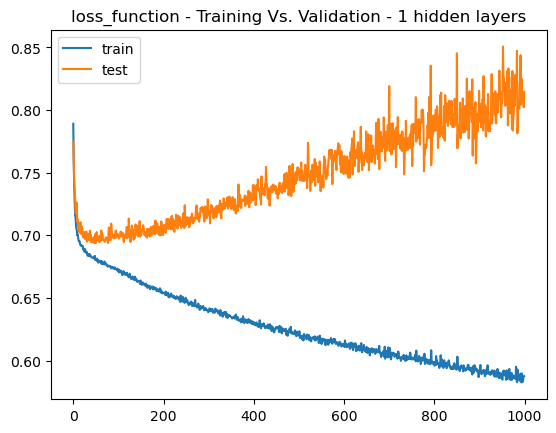

epochs=1000, hidden nodes=100, no layers=1, Loss: 0.88, Accuracy: 0.57


In [15]:
## runners_df = pd.concat([runner_starts_df,runner_wins_df,runner_placings_df],axis=1,join='inner')
# runner_starts_df
# runner_wins_df
# runner_placings_df

# trainer_df = pd.concat([trainer_starts_df,trainer_wins_df,trainer_placings_df],axis=1,join='inner')
# trainer_starts_df
# trainer_wins_df
# trainer_placings_df

# rider_df = pd.concat([rider_starts_df,rider_wins_df,rider_placings_df],axis=1,join='inner') 
# rider_starts_df
# rider_wins_df
# rider_placings_df

# fixed_wins_df
# df = df.iloc[:,0:15]

# weatherCondition_df
# trackCondition_df
# raceClassConditions_df

# raceDistance_df

# horse_df

# include = [raceDistance_df, horse_df]          #epochs=10, hidden nodes=5, no layers=1, Loss: 0.81, Accuracy: 0.78
# include = [raceDistance_df]          #epochs=10, hidden nodes=5, no layers=2, Loss: 0.81, Accuracy: 0.78
# include = [raceDistance_df,rider_wins_df]          #epochs=10, hidden nodes=5, no layers=2, Loss: 0.81, Accuracy: 0.66

# include = [trainer_df,raceDistance_df] #epochs=10, hidden nodes=5, no layers=1, Loss: 0.81, Accuracy: 0.62
# include = [trainer_df,raceDistance_df] #epochs=10, hidden nodes=5, no layers=2, Loss: 0.81, Accuracy: 0.75

# include = [weatherCondition_df,trackCondition_df,raceClassConditions_df] #epochs=10, hidden nodes=5, no layers=2, Loss: 0.82, Accuracy: 0.64
# include = [weatherCondition_df,trackCondition_df,raceClassConditions_df] #epochs=10, hidden nodes=5, no layers=1, Loss: 0.84, Accuracy: 0.61

include = [raceDistance_df, fixed_wins_df] # epochs=20, hidden nodes=1, no layers=1, Loss: 0.81, Accuracy: 0.79

no_layers = 1
epochs = 1000#50
hidden_nodes = 100#10
report,neuron,X = deep_net(X,y,include,epochs,hidden_nodes,no_layers,verbose=2) 
print(report)

In [16]:
prediction = neuron.predict(X)
# display(prediction)

y_df = pd.DataFrame(y)
y_df['pred'] = prediction
# y_df.plot()
y_df.head(5)


413/413 [==============================] - 1s 1ms/step


,finishingPosition,pred
0,0.0,-252.640106
1,0.0,-246.705597
2,0.0,-249.775604
3,0.0,-260.014130
4,1.0,-258.353058


In [17]:
y_df

,finishingPosition,pred
0,0.0,-252.640106
1,0.0,-246.705597
2,0.0,-249.775604
3,0.0,-260.014130
4,1.0,-258.353058
...,...,...
13183,2.0,-302.066010
13184,0.0,-298.470978
13185,0.0,-259.383148
13186,1.0,-261.257294


In [18]:
#     model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
#     # print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    
#     if(verbose > 0):
#         plt.plot(model.history["loss"])
#         plt.plot(model.history["val_loss"])
#         plt.title(f"loss_function - Training Vs. Validation - {no_layers} hidden layers")
#         plt.legend(["train", "test"])
#         plt.show()